# Percobaan Menggunakan Ekualisasi Histogram, Deteksi Tepi Sobel dan Filter Median

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

# Data Loading

In [2]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset/"):
    if sub_folder[0] == ".":
        continue

    sub_folder_files = os.listdir(os.path.join("dataset/", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset/", sub_folder, filename)

        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

# Data Preparation

## Define Preprocessing Function

In [3]:
def resize(image, target_size):
    result = np.zeros(target_size, image.dtype)
    step = (image.shape[0] // target_size[0], image.shape[1] // target_size[1])
    result = image[0::step[0], 0::step[1]]
    return result

# Ekualisasi Histogram
def prepro1(img):
    result = np.zeros(img.shape, dtype=img.dtype)

    eqs: np.array = np.zeros(256, np.uint8)

    hist: np.array = np.zeros(256, np.int32)
    for c in img.ravel():
        hist[int(c)] += 1

    cdf: np.array = np.zeros(256, float)

    cdf[0] = hist[0]
    for i in range(1, 256):
        cdf[i] = hist[i] + cdf[i - 1]

    eqs = np.round(cdf / cdf[-1] * 255).astype(np.uint8)
    
    result = eqs[img]

    return result

# Perbaikan Citra - Filter Median
def prepro2(img, size=(3, 3)):
    result = np.zeros(img.shape, img.dtype)

    half_kern_size = (size[0]//2 ,size[1]//2)
    padded = np.pad(img, pad_width=half_kern_size, mode="edge")
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            temp = np.sort(padded[y:y+size[0], x:x+size[1]].flatten())[(size[0] * size[1]) // 2]
            result[y,x] = temp

    return result

# Deteksi Tepi - Metode Robert
def prepro3(img):
    kernel = np.array([
        [
            [1, 0],
            [0,  -1]
        ],
        [
            [0, 1],
            [-1, 0]
        ]
    ])

    result = np.zeros(img.shape, dtype=img.dtype)

    padded = np.zeros((img.shape[0] + 1, img.shape[1] + 1), dtype=img.dtype)
    padded[1:, 1:] = img[:, :]

    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            sx = np.sum(padded[y:y+kernel[0].shape[0], x:x+kernel[0].shape[1]] * kernel[0])
            sy = np.sum(padded[y:y+kernel[0].shape[1], x:x+kernel[0].shape[1]] * kernel[1])

            result[y, x] = np.sqrt(sx**2 + sy**2)

    return result

# Deteksi Tepi - Metode Sobel
def prepro4(img):
    kernel = np.array([
        [
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ],
        [
            [1, 2, 1],
            [0, 0, 0],
            [-1, -2, -1]
        ]
    ])

    result = np.zeros(img.shape, dtype=img.dtype)

    padded = np.zeros((img.shape[0] + 2, img.shape[1] + 2), dtype=img.dtype)
    padded[2:, 2:] = img[:, :]

    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            sx = np.sum(padded[y:y+kernel[0].shape[0], x:x+kernel[0].shape[1]] * kernel[0])
            sy = np.sum(padded[y:y+kernel[0].shape[1], x:x+kernel[0].shape[1]] * kernel[1])

            result[y, x] = np.sqrt(sx**2 + sy**2)

    return result

def prepro5(img, value=120):
    result = np.zeros(img.shape, img.dtype)
    result[img > value] = 255
    return result

## Preprocessing

In [4]:
dataPreprocessed = []
for i in range(len(data)):
    img = prepro1(data[i])
    img = prepro3(img)
    img = prepro2(img)
    dataPreprocessed.append(img)

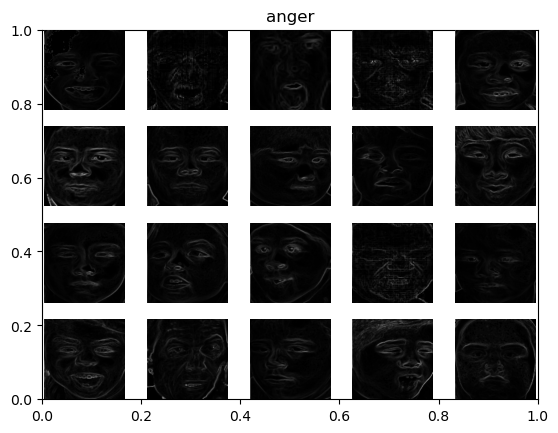

<Figure size 2000x2000 with 0 Axes>

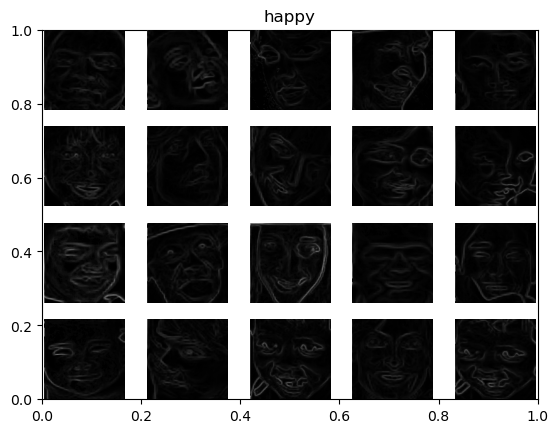

<Figure size 2000x2000 with 0 Axes>

In [5]:
step = 100 # Jumlah Gambar Per Label
for i in range(len(dataPreprocessed) // step):
    plt.title(labels[i * step])
    for j in range(0, 20):
        plt.subplot(4, 5, j + 1)
        plt.imshow(dataPreprocessed[(i * step) + j], cmap="gray")
        plt.axis(False)

    plt.figure(figsize=(20, 20))
    plt.tight_layout()
    plt.show()

## Feature Extraction

In [6]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [7]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [8]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [9]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [10]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [11]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [12]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [13]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [14]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [15]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [16]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [17]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [18]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [19]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [20]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [21]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [22]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

## Write the extraction's results to CSV

In [23]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_4.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_4.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,anger016.png,anger,54.175288,127.325263,95.439061,139.180780,0.726351,0.634397,0.697846,0.646295,...,0.052794,0.046906,0.232468,0.214550,0.229770,0.216578,0.828424,0.491985,0.661842,0.444661
1,anger003.png,anger,117.597934,180.865451,84.695328,178.502041,0.509909,0.420009,0.689685,0.421094,...,0.054875,0.020308,0.159884,0.142158,0.234254,0.142505,0.646428,0.371467,0.741434,0.379707
2,anger15662.png,anger,8.497377,58.963402,53.120295,57.395162,0.661783,0.588046,0.683884,0.581271,...,0.029981,0.021094,0.164149,0.147924,0.173149,0.145237,0.960106,0.653441,0.689305,0.662796
3,anger004.png,anger,128.630225,343.100203,247.139954,348.893684,0.559460,0.372819,0.509565,0.369611,...,0.020698,0.011686,0.147729,0.108775,0.143869,0.108104,0.791439,0.321512,0.571193,0.310067
4,anger030.png,anger,74.644359,147.017254,80.817465,147.327555,0.625358,0.513573,0.587542,0.509248,...,0.022921,0.018054,0.157841,0.134724,0.151396,0.134365,0.816041,0.577011,0.801590,0.576466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,happy132.png,happy,14.803451,92.316857,82.085122,93.890285,0.715079,0.589065,0.672128,0.615794,...,0.032615,0.027724,0.191290,0.158490,0.180597,0.166506,0.944412,0.539283,0.610098,0.533236
196,happy091.png,happy,36.219110,113.614229,81.795424,114.305295,0.623126,0.526140,0.610107,0.514878,...,0.017462,0.012280,0.131982,0.113171,0.132145,0.110816,0.870801,0.470384,0.661382,0.468195
197,happy101.png,happy,51.328035,112.530998,67.664158,112.915422,0.694057,0.614204,0.689916,0.610955,...,0.043665,0.033528,0.207666,0.186804,0.208963,0.183107,0.839841,0.584510,0.780673,0.583300
198,happy192.png,happy,95.588025,176.947415,86.961903,175.712200,0.616510,0.520228,0.607580,0.525733,...,0.016802,0.012491,0.128186,0.111819,0.129624,0.111762,0.738078,0.381977,0.762492,0.388313


## Features Selection

<Axes: >

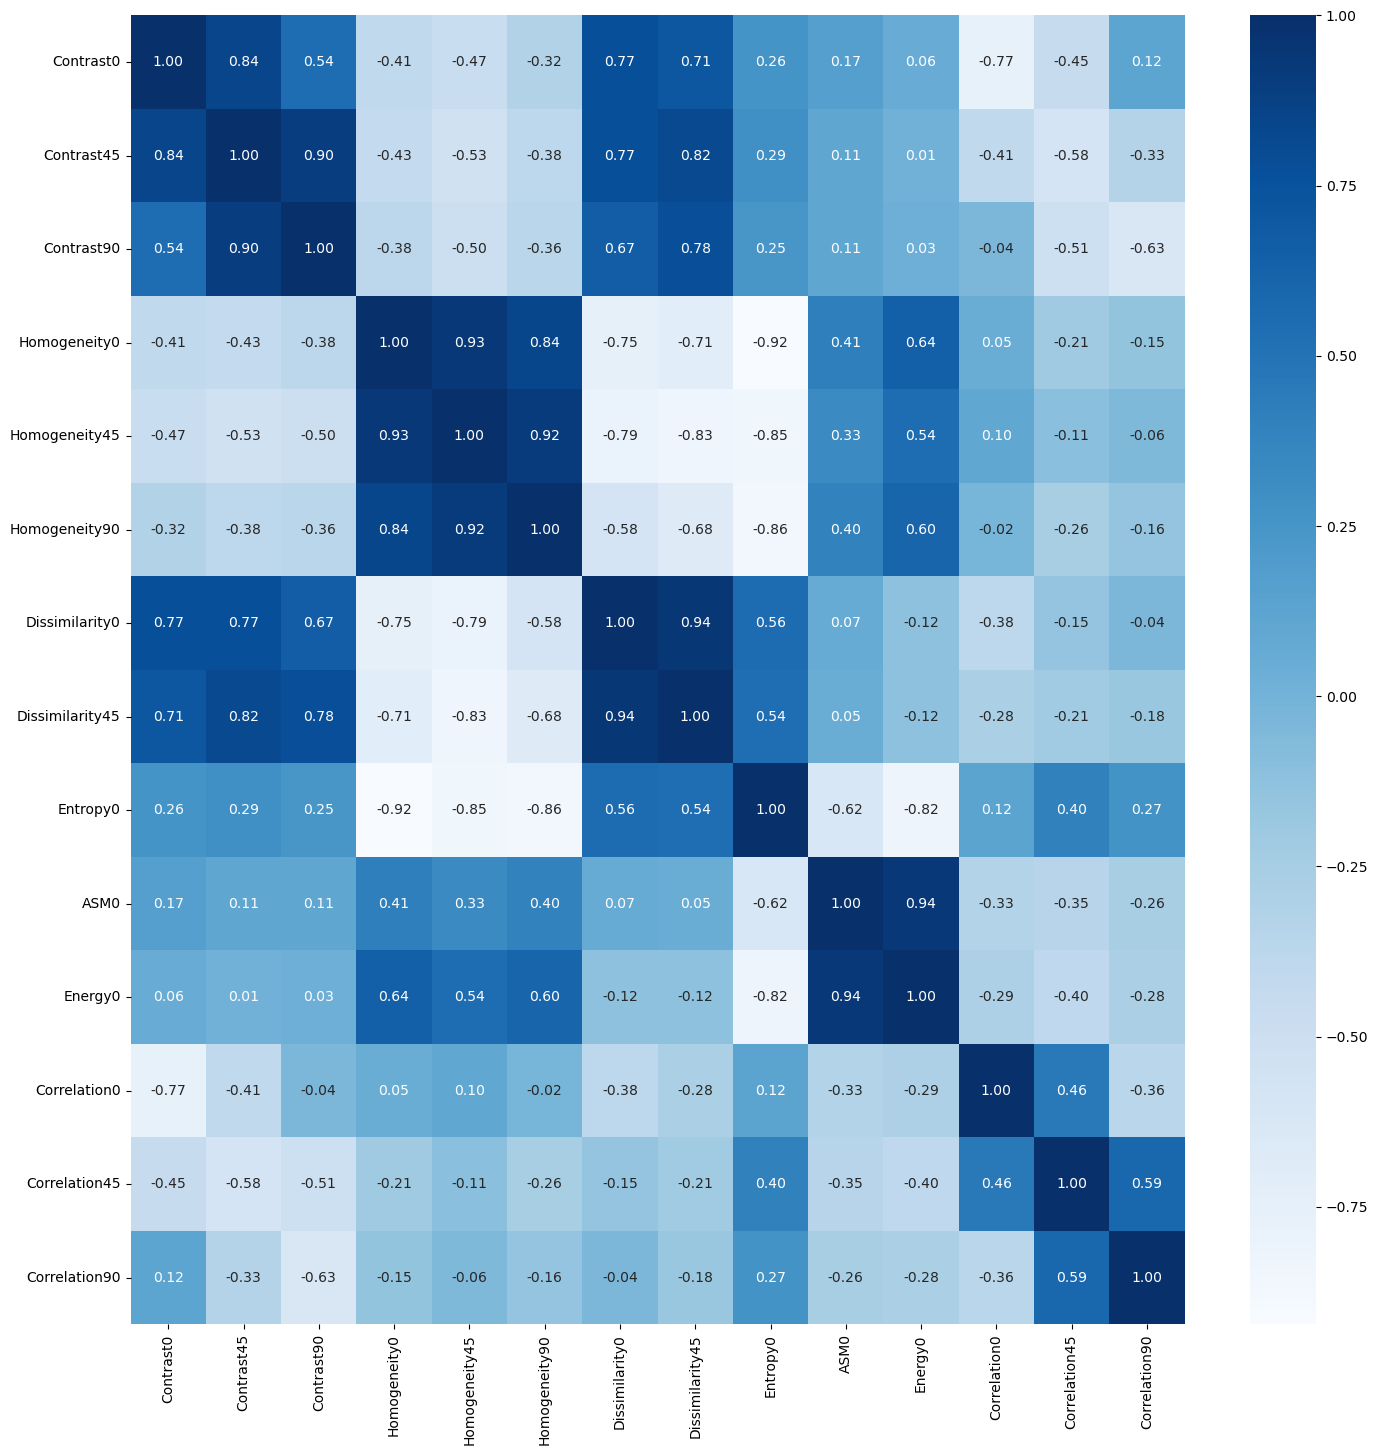

In [24]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [25]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 14)
(40, 14)


## Feature Normalization

In [26]:
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

# Modelling

## Define Modelling

In [27]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

## Train Random Forest Classifier

In [28]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       anger       0.97      0.99      0.98        79
       happy       0.99      0.98      0.98        81

    accuracy                           0.98       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.98      0.98      0.98       160

[[78  1]
 [ 2 79]]
Accuracy: 0.98125

------Testing Set------
              precision    recall  f1-score   support

       anger       0.78      0.86      0.82        21
       happy       0.82      0.74      0.78        19

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40

[[18  3]
 [ 5 14]]
Accuracy: 0.8


## Tain SVM Classifier

In [29]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       anger       0.84      0.87      0.86        79
       happy       0.87      0.84      0.86        81

    accuracy                           0.86       160
   macro avg       0.86      0.86      0.86       160
weighted avg       0.86      0.86      0.86       160

[[69 10]
 [13 68]]
Accuracy: 0.85625

------Testing Set------
              precision    recall  f1-score   support

       anger       0.83      0.90      0.86        21
       happy       0.88      0.79      0.83        19

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40

[[19  2]
 [ 4 15]]
Accuracy: 0.85


## Train KNN Classifier

In [30]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       anger       0.76      0.78      0.77        79
       happy       0.78      0.75      0.77        81

    accuracy                           0.77       160
   macro avg       0.77      0.77      0.77       160
weighted avg       0.77      0.77      0.77       160

[[62 17]
 [20 61]]
Accuracy: 0.76875

------Testing Set------
              precision    recall  f1-score   support

       anger       0.76      0.90      0.83        21
       happy       0.87      0.68      0.76        19

    accuracy                           0.80        40
   macro avg       0.81      0.79      0.80        40
weighted avg       0.81      0.80      0.80        40

[[19  2]
 [ 6 13]]
Accuracy: 0.8


## Evaluation With Confusion Matrix

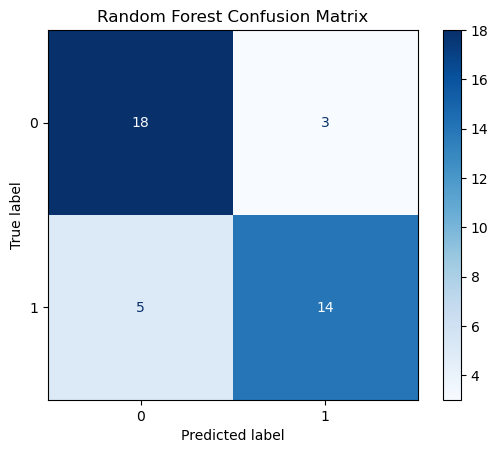

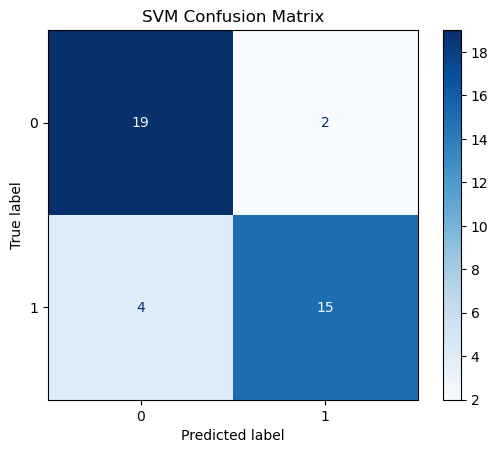

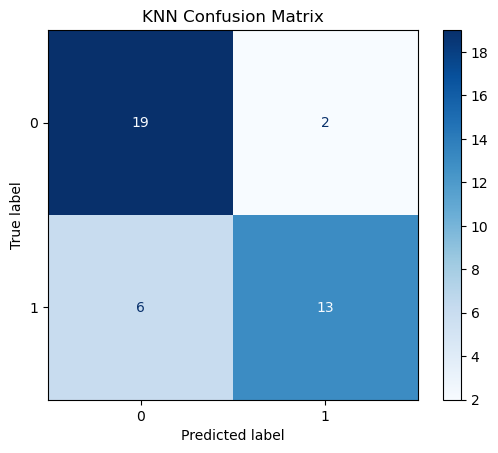

In [31]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")